In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mediapipe as mp
import cv2
import math
import os
import landmarks as lm
import mask as m
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skimage.feature import local_binary_pattern

In [15]:
dataPath = './resources/CK+48/'
dirs = ['anger','disgust','fear','happy','sad','surprise']
# dirs = ['angry']
X = []
y = []
for c, d in enumerate(dirs):
    fileList = sorted(os.listdir(dataPath+d))
    print(d,c)
    for i,fileName in enumerate(fileList):
        img = cv2.imread(os.path.join(dataPath,d+'/'+fileName))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        X.append(img)
        y.append(c)
        if np.shape(img)[0] != 762:
            print(f"{i+1}. Filename: {fileName}, shape: {np.shape(img)}")

anger 0
1. Filename: S010_004_00000017.png, shape: (48, 48)
2. Filename: S010_004_00000018.png, shape: (48, 48)
3. Filename: S010_004_00000019.png, shape: (48, 48)
4. Filename: S011_004_00000019.png, shape: (48, 48)
5. Filename: S011_004_00000020.png, shape: (48, 48)
6. Filename: S011_004_00000021.png, shape: (48, 48)
7. Filename: S014_003_00000028.png, shape: (48, 48)
8. Filename: S014_003_00000029.png, shape: (48, 48)
9. Filename: S014_003_00000030.png, shape: (48, 48)
10. Filename: S022_005_00000030.png, shape: (48, 48)
11. Filename: S022_005_00000031.png, shape: (48, 48)
12. Filename: S022_005_00000032.png, shape: (48, 48)
13. Filename: S026_003_00000013.png, shape: (48, 48)
14. Filename: S026_003_00000014.png, shape: (48, 48)
15. Filename: S026_003_00000015.png, shape: (48, 48)
16. Filename: S028_001_00000022.png, shape: (48, 48)
17. Filename: S028_001_00000023.png, shape: (48, 48)
18. Filename: S028_001_00000024.png, shape: (48, 48)
19. Filename: S029_001_00000017.png, shape: (48

In [16]:
X = np.array(X)
y = np.array(y)
print(f"X shape = {X.shape}")
print(f"y shape = {y.shape}")

X shape = (927, 48, 48)
y shape = (927,)


In [17]:
# string labels
emo = ['angry', 
           'disgust',
            'fear',
            'happy',
            'sad',
            'surprise',
            # 'neutral'
]

In [18]:
# count classes
emotions, counts =np.unique(y, return_counts=True)
for c, count in zip(emotions, counts):
    print(f"{emo[c]} count = {count}")

angry count = 135
disgust count = 177
fear count = 75
happy count = 207
sad count = 84
surprise count = 249


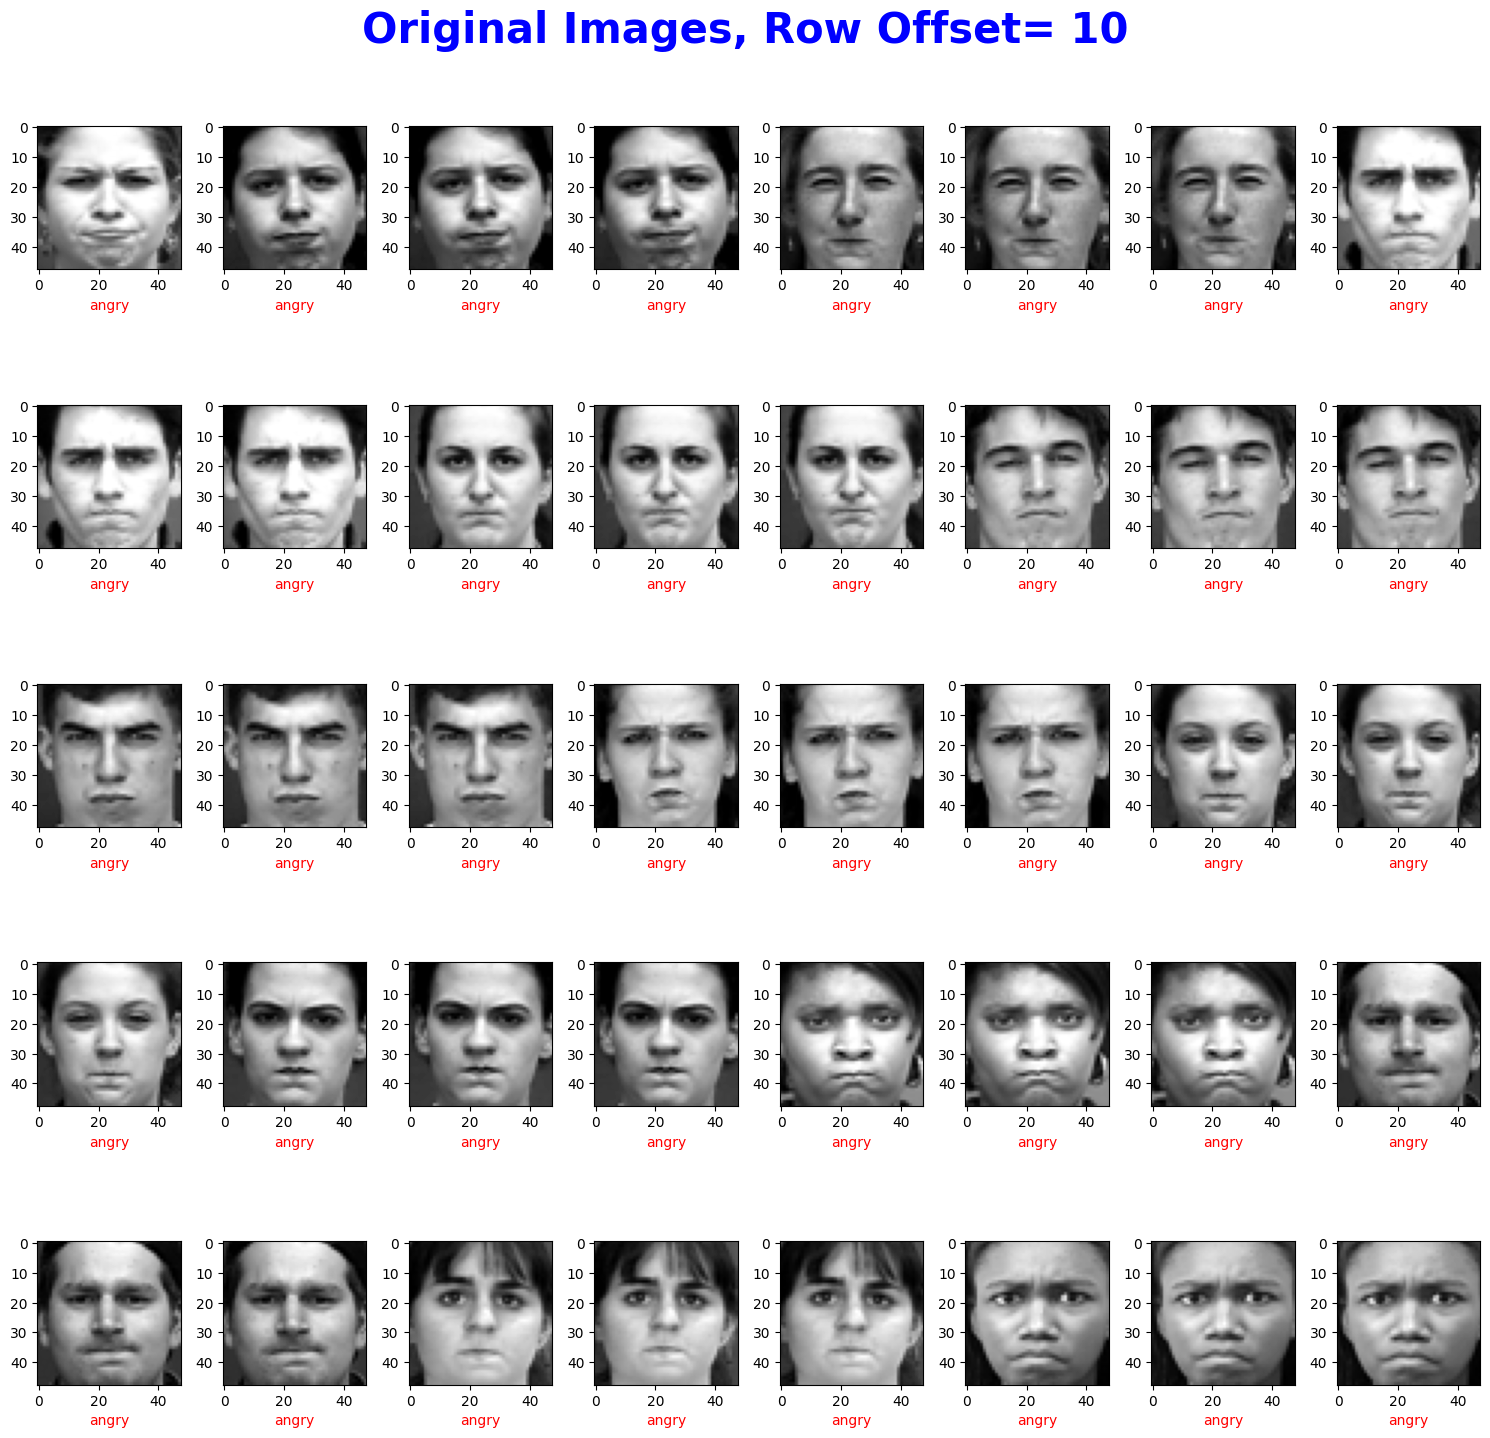

In [19]:
# have a peek at the images
rowOffset = 10
nRows = 5
nCols = 8
fig, axes = plt.subplots(nRows, nCols, figsize=(15, 15))
fig.suptitle(f'Original Images, Row Offset= {rowOffset}', fontsize=30, color='blue', fontweight='bold')

for i in range(nRows):
    for j in range(nCols):
        ax = axes[i, j]
        ax.imshow(X[(i+rowOffset)*nCols+j,:,:], cmap='gray')
        ax.set_xlabel(emo[y[(i+rowOffset)*nCols+j]], c='r')
plt.tight_layout()
plt.show()


# Extract Face Landmarks

In [20]:
WEBCAM = False
IMG = True

In [21]:
# face mask image size
targetSize = (96,96)

In [22]:
# Face Mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

# Face detection
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

writeDataPath = './resources/'

In [23]:
# For static images:
IMAGES = X[:]

if IMG:
  imgLandmarkLabelArray = []
  landmarkDisplayArray = []
  faceMaskCroppedArray = []
  faceCroppedArray = []
  xPos = []
  yPos = []
  zPos = []
  baseIPD = 500 # standard base IPD setting for upscaling
  thres = 10 # face turn in pixels 

  # main detect loop
  with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5) as face_mesh:
    
    # image process 
    for idx, image in enumerate(IMAGES):
      xPos = []
      yPos = []
      zPos = []
      faceLinesOrdered = []

      # Convert to BGR image before processing.
      annotated_image = image.copy()
      annotated_image = cv2.resize(annotated_image, (216,216))
      annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR) 
      annotated_image_4crop = annotated_image.copy()

      # 3D landmark detection
      results = face_mesh.process(annotated_image)
      imgMatrix = []

      # Get the shape of the annotated_image
      h, w, c = annotated_image.shape

      # create black background
      blackImg = np.zeros((h, w, c), np.uint8)

      # Print and draw face mesh landmarks on the image.
      if not results.multi_face_landmarks:
        print(f"Level 1: Face not detected in image#{idx}")
        continue
      for face_landmarks in results.multi_face_landmarks:
        # Compute Interpupillary Distance (IPD)
        leftPupilx = int(face_landmarks.landmark[386].x*annotated_image.shape[1])
        leftPupily = int(face_landmarks.landmark[386].y*annotated_image.shape[0])
        leftPupilz = int(face_landmarks.landmark[386].z*annotated_image.shape[1])

        rightPupilx = int(face_landmarks.landmark[159].x*annotated_image.shape[1])
        rightPupily = int(face_landmarks.landmark[159].y*annotated_image.shape[0])
        rightPupilz = int(face_landmarks.landmark[159].z*annotated_image.shape[1])

        # cv2.line(annotated_image, (leftPupilx, leftPupily), (rightPupilx, rightPupily), (0, 255, 255), thickness=2)
        # cv2.circle(annotated_image, (leftPupilx, leftPupily), 2, (0, 255, 255), -1)
        # cv2.circle(annotated_image, (rightPupilx, rightPupily), 2, (0, 255, 255), -1)

        ipd = math.sqrt((rightPupilx-leftPupilx)**2 + (rightPupily-leftPupily)**2 + (rightPupilz-leftPupilz)**2)

        # #3D landmark generation
        for fnum,selectedLandmark in enumerate(lm.selectedLandmarks): # 3D face landmarks
          cx = int(face_landmarks.landmark[selectedLandmark[0]].x*annotated_image.shape[1])
          cy = int(face_landmarks.landmark[selectedLandmark[0]].y*annotated_image.shape[0])
          cz = int(face_landmarks.landmark[selectedLandmark[0]].z*annotated_image.shape[1])
          cx2 = int(face_landmarks.landmark[selectedLandmark[1]].x*annotated_image.shape[1])
          cy2 = int(face_landmarks.landmark[selectedLandmark[1]].y*annotated_image.shape[0])
          cz2 = int(face_landmarks.landmark[selectedLandmark[1]].z*annotated_image.shape[1])

          cv2.line(annotated_image, (cx, cy), (cx2, cy2), (0, 255, 0), thickness=2 )
          cv2.circle(annotated_image, (cx, cy), 1, (0, 255, 0), -1)
          cv2.circle(annotated_image, (cx2, cy2), 1, (0, 255, 0), -1)

          # for plotting
          xPos.append(cx)
          yPos.append(cy)
          zPos.append(cz)
          xPos.append(cx2)
          yPos.append(cy2)
          zPos.append(cz2)
          
          # compute Euclidean distance between coordinates and scale it based on base IPD
          imgMatrix.append(math.sqrt((cx2-cx)**2 + (cy2-cy)**2 + (cz2-cz)**2) * (baseIPD/ipd))
          if (math.sqrt((cx2-cx)**2 + (cy2-cy)**2 + (cz2-cz)**2) * (baseIPD/ipd)) == 0:
            print(f"Dist = 0.0 at feature number {fnum}, landmarknum =({selectedLandmark[0]},{selectedLandmark[1]})")

        # face mask generation
        for selectedLandmark in m.selectedLandmarks: # Cropped images and face masks landmarks
          cx = int(face_landmarks.landmark[selectedLandmark[0]].x*annotated_image.shape[1])
          cy = int(face_landmarks.landmark[selectedLandmark[0]].y*annotated_image.shape[0])
          cz = int(face_landmarks.landmark[selectedLandmark[0]].z*annotated_image.shape[1])
          cx2 = int(face_landmarks.landmark[selectedLandmark[1]].x*annotated_image.shape[1])
          cy2 = int(face_landmarks.landmark[selectedLandmark[1]].y*annotated_image.shape[0])
          cz2 = int(face_landmarks.landmark[selectedLandmark[1]].z*annotated_image.shape[1])

          #overlay landmarks on blackImg
          cv2.line(blackImg, (cx, cy), (cx2, cy2), (255, 255, 255), thickness=2 )
          
        # cropped face generation
        for faceOutline in lm.faceOutlines: # face crop
          cx = int(face_landmarks.landmark[faceOutline[0]].x*annotated_image_4crop.shape[1])
          cy = int(face_landmarks.landmark[faceOutline[0]].y*annotated_image_4crop.shape[0])
          cx2 = int(face_landmarks.landmark[faceOutline[1]].x*annotated_image_4crop.shape[1])
          cy2 = int(face_landmarks.landmark[faceOutline[1]].y*annotated_image_4crop.shape[0])

          # cv2.line(annotated_image_4crop, (cx, cy), (cx2, cy2), (255, 255, 255), thickness=1)
          # cv2.circle(annotated_image_4crop, (cx, cy), 1, (255, 255, 255), -1)
          # cv2.circle(annotated_image_4crop, (cx2, cy2), 1, (255, 255, 255), -1)
        
        # check for non-frontal face
        # left profile
        if abs(face_landmarks.landmark[323].x*annotated_image_4crop.shape[1] - face_landmarks.landmark[4].x*annotated_image_4crop.shape[1]) < thres or \
          abs(face_landmarks.landmark[361].x*annotated_image_4crop.shape[1] - face_landmarks.landmark[4].x*annotated_image_4crop.shape[1]) < thres:
          
          for left in lm.leftFaceOutlineArray:
            cx_ = int(face_landmarks.landmark[left].x*annotated_image_4crop.shape[1])
            cy_ = int(face_landmarks.landmark[left].y*annotated_image_4crop.shape[0])
            faceLinesOrdered.append([cx_,cy_])
          
        # right profile
        elif abs(face_landmarks.landmark[4].x*annotated_image_4crop.shape[1] - face_landmarks.landmark[132].x*annotated_image_4crop.shape[1]) < thres or \
          abs(face_landmarks.landmark[4].x*annotated_image_4crop.shape[1] - face_landmarks.landmark[93].x*annotated_image_4crop.shape[1]) < thres:

          for right in lm.rightFaceOutlineArray:
            cx_ = int(face_landmarks.landmark[right].x*annotated_image_4crop.shape[1])
            cy_ = int(face_landmarks.landmark[right].y*annotated_image_4crop.shape[0])
            faceLinesOrdered.append([cx_,cy_])
        
        # frontal
        else:
          for p in lm.faceOutlineArray:
            cx_ = int(face_landmarks.landmark[p].x*annotated_image_4crop.shape[1])
            cy_ = int(face_landmarks.landmark[p].y*annotated_image_4crop.shape[0])
            faceLinesOrdered.append([cx_,cy_])
          
        mask = np.zeros((annotated_image_4crop.shape[0], annotated_image_4crop.shape[1]))
        mask = cv2.fillConvexPoly(mask, np.array(faceLinesOrdered), 255)
        mask = mask.astype(bool)
        out = np.zeros_like(annotated_image_4crop)
        out[mask] = annotated_image_4crop[mask]
        annotated_image_4crop = out
          
      ### Cropped face
      # detect face
      faceResults = face_detection.process(annotated_image_4crop)
      
      if faceResults.detections:
        detection = faceResults.detections[0]
        bbox = detection.location_data.relative_bounding_box
        h, w, c = annotated_image_4crop.shape
        bbox_xmin = int(bbox.xmin * w)
        bbox_ymin = int(bbox.ymin * h)
        bbox_width = int(bbox.width * w)
        bbox_height = int(bbox.height * h)
        
        if bbox_xmin <= 0 or bbox_ymin <= 0 or bbox_width <= 0 or bbox_height <= 0:
          print(f"Level 2: Face not detected in image#{idx}")
          continue
        
        #### Append 3D Landmarks & labels
        imgMatrix.append(y[idx])
        imgLandmarkLabelArray.append(imgMatrix)

        #### Append Cropped face
        faceCropped = annotated_image_4crop[bbox_ymin:bbox_ymin+bbox_height, bbox_xmin:bbox_xmin+bbox_width]
        size = min(faceCropped.shape[0], faceCropped.shape[1])
        faceCropped = faceCropped[0:size, 0:size]
        # resize to target size and drop two channels
        faceCropped = cv2.resize(faceCropped, targetSize)
        # faceCroppedArray.append(faceCropped[:,:,:1])
        faceCroppedArray.append(faceCropped[:,:,:])
        
        # Append Cropped face mask
        faceMaskCropped = blackImg[bbox_ymin:bbox_ymin+bbox_height, bbox_xmin:bbox_xmin+bbox_width]
        size = min(faceMaskCropped.shape[0], faceMaskCropped.shape[1])
        faceMaskCropped = faceMaskCropped[0:size, 0:size]
        # resize to target size and drop two channels
        faceMaskCropped = cv2.resize(faceMaskCropped, targetSize)
        faceMaskCroppedArray.append(faceMaskCropped[:,:,:])

        print(f"appended image#{idx}")
        
        text = f"IPD = {round(ipd,2)}"
        cv2.putText(annotated_image, text, (30,30), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0,255,255), 1)
        # cv2.rectangle(annotated_image, (bbox_xmin, bbox_ymin), (bbox_xmin + bbox_width, bbox_ymin + bbox_height), (0, 255, 0), 2)
        landmarkDisplayArray.append(annotated_image[:,:,:])
        
        # cv2.imshow('Face Image', annotated_image)
        # cv2.imshow('Cropped Image', faceCropped)
        # cv2.imshow('Cropped Face Mask',faceMaskCropped)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        # cv2.waitKey(1)

  imgLandmarkLabelArray = np.array(imgLandmarkLabelArray)
  landmarkDisplayArray = np.array(landmarkDisplayArray)

  # append header of optimised dataset
  hds = []
  for i in range(len(imgLandmarkLabelArray[1])-1):
      hds.append('F'+str(i))
  hds.append('emotion')

  # write 3D landmarks and labels to csv file
  imgLandmarkLabelArray = pd.DataFrame(imgLandmarkLabelArray,columns=hds)
  # imgLandmarkLabelArray.to_csv(writeDataPath+'features/landmarksCKPLUS.csv', index=False)

  # # write cropped image to numpy binary format
  # np.savez_compressed(writeDataPath+'features/CroppedCKPLUS.npz', img=faceCroppedArray)

  # # write cropped face maksk to numpy binary format
  # np.savez_compressed(writeDataPath+'features/faceMaskCKPLUS.npz', img=faceMaskCroppedArray)

if WEBCAM:
  # For webcam input:
  cap = cv2.VideoCapture(0)
  with mp_face_mesh.FaceMesh(
      max_num_faces=1,
      refine_landmarks=True,
      min_detection_confidence=0.5,
      min_tracking_confidence=0.5) as face_mesh:
    while cap.isOpened():
      success, image = cap.read()
      if not success:
        print("Ignoring empty camera frame.")
        # If loading a video, use 'break' instead of 'continue'.
        continue

      # To improve performance, optionally mark the image as not writeable to
      # pass by reference.
      image.flags.writeable = False
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      results = face_mesh.process(image)

      # https://github.com/google/mediapipe/blob/master/mediapipe/python/solutions/face_mesh_connections.py
      image.flags.writeable = True
      image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

      if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
          # Compute Interpupillary Distance (IPD)
          leftPupilx = int(face_landmarks.landmark[386].x*image.shape[1])
          leftPupily = int(face_landmarks.landmark[386].y*image.shape[0])
          leftPupilz = int(face_landmarks.landmark[386].z*image.shape[1])

          rightPupilx = int(face_landmarks.landmark[159].x*image.shape[1])
          rightPupily = int(face_landmarks.landmark[159].y*image.shape[0])
          rightPupilz = int(face_landmarks.landmark[159].z*image.shape[1])

          cv2.line(image, (leftPupilx, leftPupily), (rightPupilx, rightPupily), (0, 255, 255), thickness=2 )
          cv2.circle(image, (leftPupilx, leftPupily), 2, (0, 255, 255), -1)
          cv2.circle(image, (rightPupilx, rightPupily), 2, (0, 255, 255), -1)

          ipd = math.sqrt((rightPupilx-leftPupilx)**2 + (rightPupily-leftPupily)**2 + (rightPupilz-leftPupilz)**2)

          for selectedLandmark in lm.selectedLandmarks:
            cx = int(face_landmarks.landmark[selectedLandmark[0]].x*image.shape[1])
            cy = int(face_landmarks.landmark[selectedLandmark[0]].y*image.shape[0])
            cx2 = int(face_landmarks.landmark[selectedLandmark[1]].x*image.shape[1])
            cy2 = int(face_landmarks.landmark[selectedLandmark[1]].y*image.shape[0])

            cv2.line(image, (cx, cy), (cx2, cy2), (0, 0, 255), thickness=2)
            cv2.circle(image, (cx, cy), 5, (0, 0, 255), -1)
            cv2.circle(image, (cx2, cy2), 5, (0, 0, 255), -1)

          
      # Flip the image horizontally for a selfie-view display.
      text = f"IPD = {ipd}"
      image = cv2.flip(image, 1)
      cv2.putText(image, text, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,255,255), 2)
      cv2.imshow('Face Mesh', image)
      if cv2.waitKey(1) & 0xFF == ord("q"):
        break

    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)




appended image#0
appended image#1
appended image#2
Level 2: Face not detected in image#3
appended image#4
appended image#5
appended image#6
appended image#7
appended image#8
appended image#9
appended image#10
appended image#11
appended image#12
appended image#13
appended image#14
appended image#15
appended image#16
appended image#17
appended image#18
appended image#19
appended image#20
appended image#21
appended image#22
appended image#23
appended image#24
appended image#25
appended image#26
appended image#27
appended image#28
appended image#29
Level 2: Face not detected in image#30
appended image#31
appended image#32
appended image#33
appended image#34
appended image#35
appended image#36
appended image#37
appended image#38
appended image#39
appended image#40
appended image#41
appended image#42
appended image#43
Level 2: Face not detected in image#44
Level 2: Face not detected in image#45
Level 2: Face not detected in image#46
Level 2: Face not detected in image#47
appended image#48
ap

## Verify file read

landmarksKDEFLoaded shape: (840, 207)
croppedKDEFLoaded shape: (840, 96, 96, 3)
faceMaskKDEFLoaded shape: (840, 96, 96, 3)


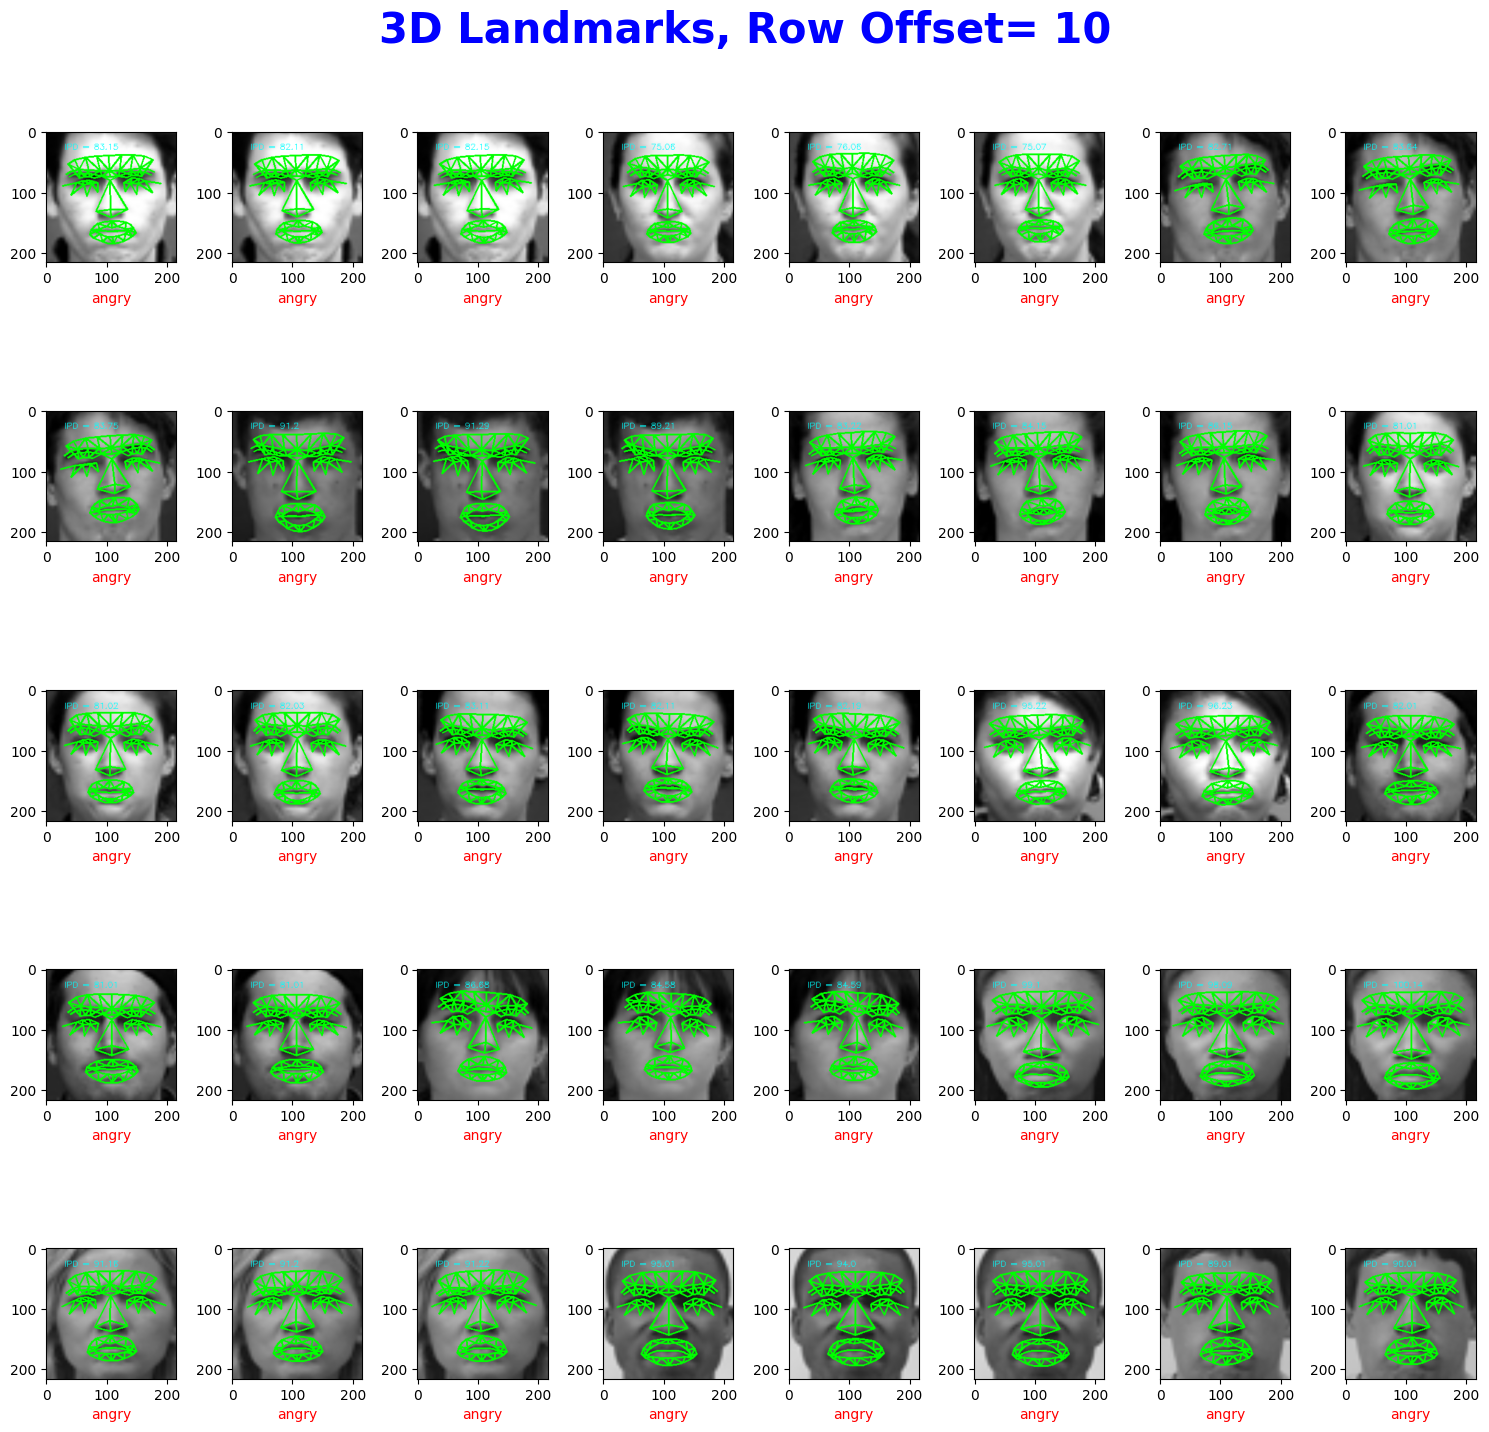

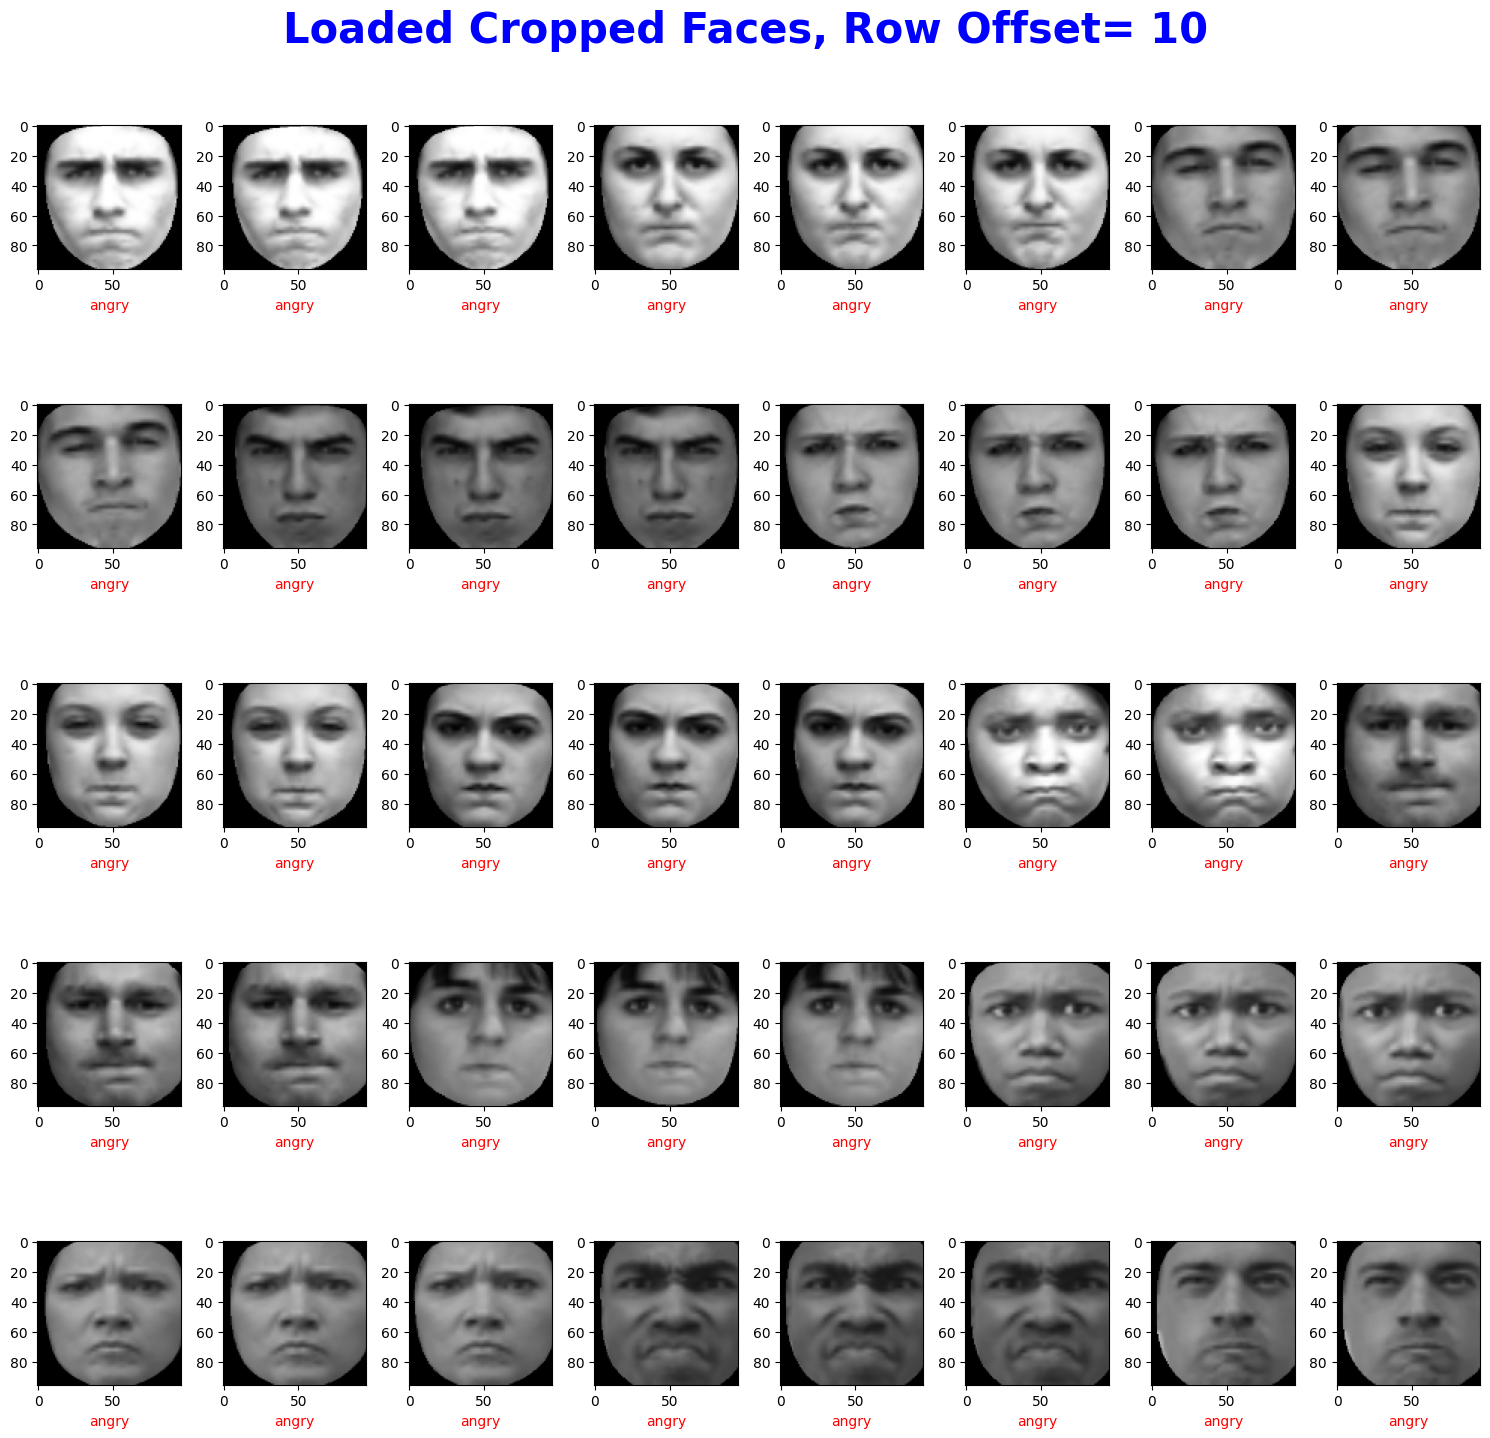

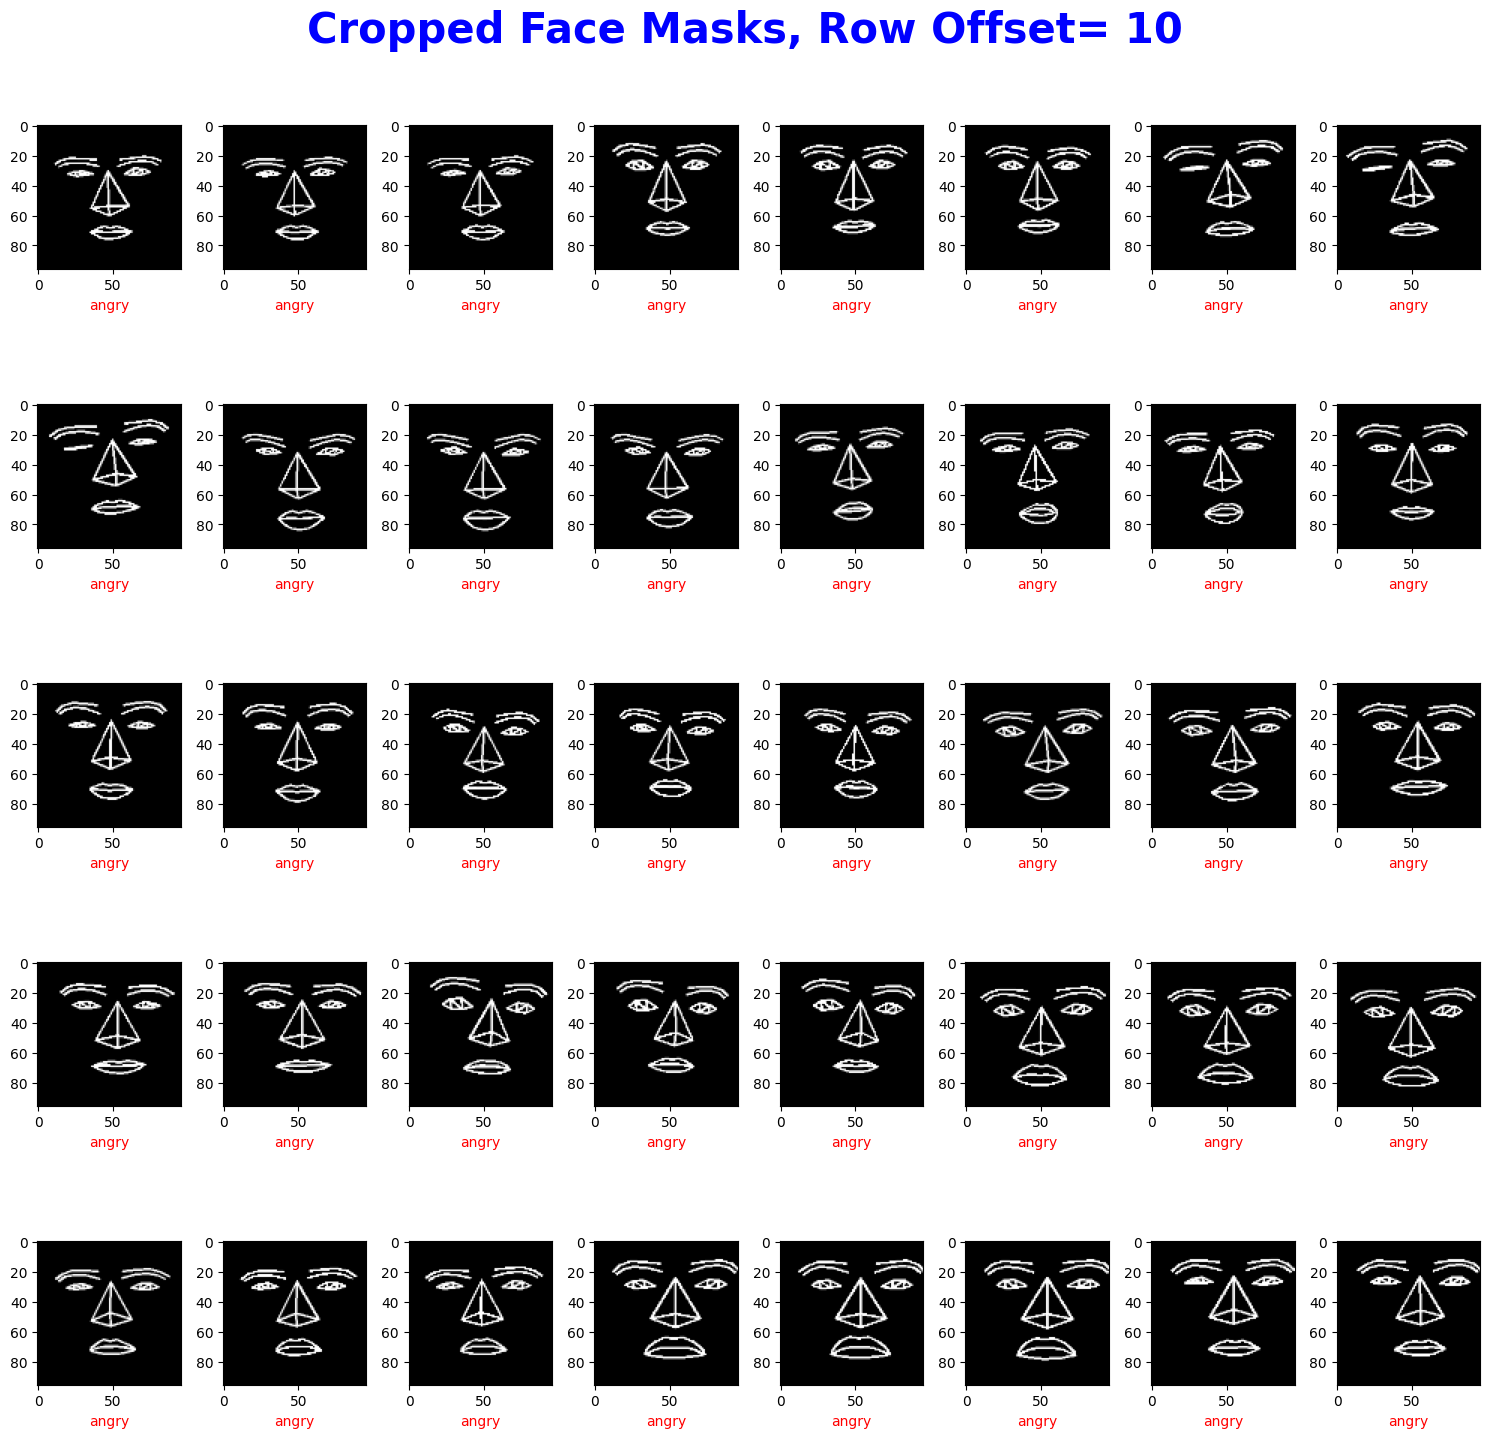

In [24]:
# load feature datasets from the NPZ files
landmarksKDEFLoaded = pd.read_csv(writeDataPath+'features/landmarksCKPLUS.csv')
croppedKDEFLoaded = np.load(writeDataPath+'features/CroppedCKPLUS.npz')['img']
faceMaskKDEFLoaded = np.load(writeDataPath+'features/faceMaskCKPLUS.npz')['img']

print(f"landmarksKDEFLoaded shape: {landmarksKDEFLoaded.shape}\ncroppedKDEFLoaded shape: {croppedKDEFLoaded.shape}\nfaceMaskKDEFLoaded shape: {faceMaskKDEFLoaded.shape}")

# 3D landmarks
nRows = 5
nCols = 8
fig, axes = plt.subplots(nRows, nCols, figsize=(15, 15))
fig.suptitle(f'3D Landmarks, Row Offset= {rowOffset}', fontsize=30, color='blue', fontweight='bold')

for i in range(nRows):
    for j in range(nCols):
        ax = axes[i, j]
        ax.imshow(landmarkDisplayArray[(i+rowOffset)*nCols+j,:,:], cmap='gray')
        ax.set_xlabel(emo[imgLandmarkLabelArray['emotion'][(i+rowOffset)*nCols+j].astype('int8')], c='r')
plt.tight_layout()
plt.show()

# cropped faces
nRows = 5
nCols = 8
fig, axes = plt.subplots(nRows, nCols, figsize=(15, 15))
fig.suptitle(f'Loaded Cropped Faces, Row Offset= {rowOffset}', fontsize=30, color='blue', fontweight='bold')
for i in range(nRows):
    for j in range(nCols):
        ax = axes[i, j]
        ax.imshow(croppedKDEFLoaded[(i+rowOffset)*nCols+j,:,:], cmap='gray')
        ax.set_xlabel(emo[imgLandmarkLabelArray['emotion'][(i+rowOffset)*nCols+j].astype('int8')], c='r')
plt.tight_layout()
plt.show()

# cropped face masks
nRows = 5
nCols = 8
fig, axes = plt.subplots(nRows, nCols, figsize=(15, 15))
fig.suptitle(f'Cropped Face Masks, Row Offset= {rowOffset}', fontsize=30, color='blue', fontweight='bold')
for i in range(nRows):
    for j in range(nCols):
        ax = axes[i, j]
        ax.imshow(faceMaskKDEFLoaded[(i+rowOffset)*nCols+j,:,:], cmap='gray')
        ax.set_xlabel(emo[imgLandmarkLabelArray['emotion'][(i+rowOffset)*nCols+j].astype('int8')], c='r')
plt.tight_layout()
plt.show()



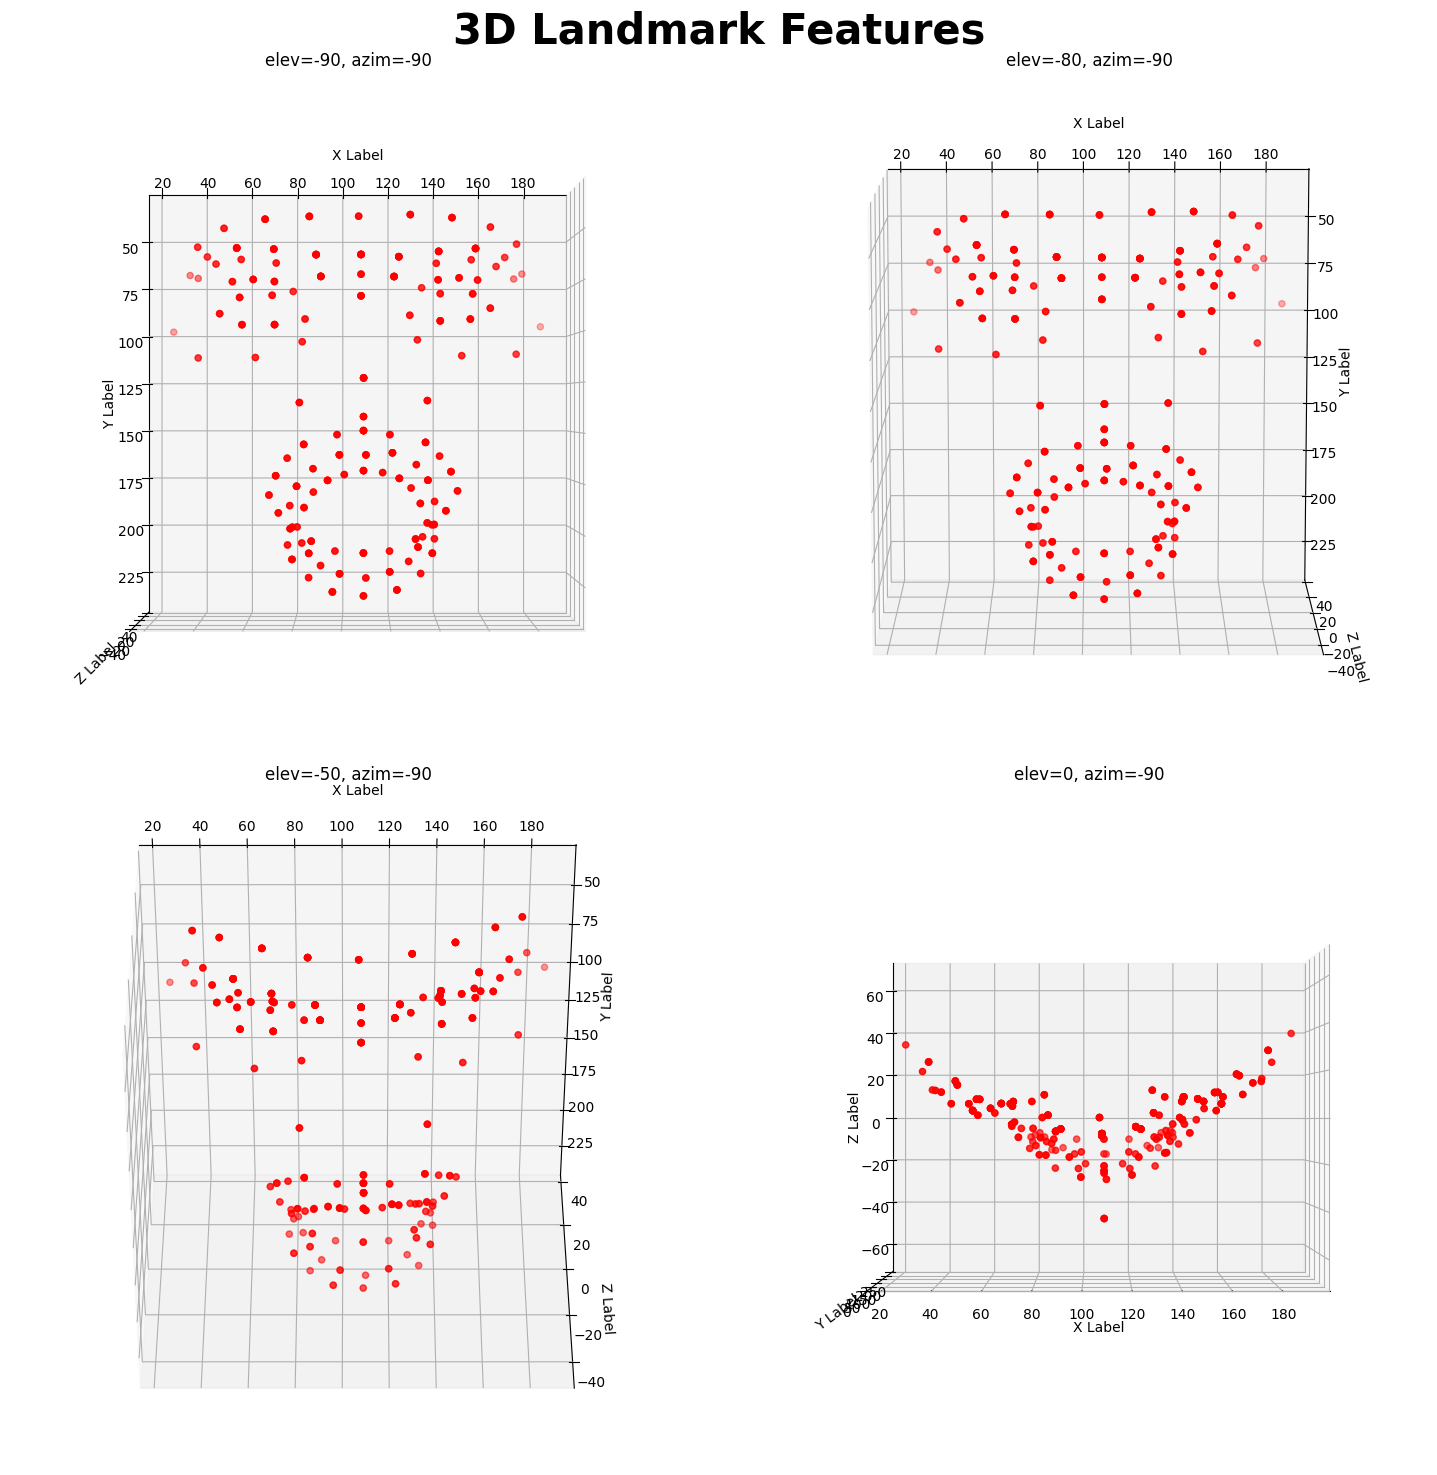

In [25]:
# Create a 3D plot
fig= plt.figure(figsize=(15,15))
fig.suptitle(f'3D Landmark Features', fontsize=30, color='black', fontweight='bold')
ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(xPos, yPos, zPos, c='red')
ax1.set_xlabel('X Label')
ax1.set_ylabel('Y Label')
ax1.set_zlabel('Z Label')
ax1.set_title('elev=-90, azim=-90')
ax1.view_init(elev=-90, azim=-90)

ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(xPos, yPos, zPos, c='red')
ax2.set_xlabel('X Label')
ax2.set_ylabel('Y Label')
ax2.set_zlabel('Z Label')
ax2.set_title('elev=-80, azim=-90')
ax2.view_init(elev=-80, azim=-90)

ax3 = fig.add_subplot(223, projection='3d')
ax3.scatter(xPos, yPos, zPos, c='red')
ax3.set_xlabel('X Label')
ax3.set_ylabel('Y Label')
ax3.set_zlabel('Z Label')
ax3.set_title('elev=-50, azim=-90')
ax3.view_init(elev=-50, azim=-90)

ax4 = fig.add_subplot(224, projection='3d')
ax4.scatter(xPos, yPos, zPos, c='red')
ax4.set_xlabel('X Label')
ax4.set_ylabel('Y Label')
ax4.set_zlabel('Z Label')
ax4.set_title('elev=0, azim=-90')

ax4.set_ylim3d(0, 256)
ax4.set_ylim3d(0, 256)
ax4.set_zlim3d(-70, 70)

ax4.view_init(elev=0, azim=-90)

plt.tight_layout()
plt.show()